In [95]:
import pandas as pd

from plotnine import *

import rpy2.robjects as ro
import rpy2.rinterface as ri
import rpy2.robjects.packages as rpackages
import rpy2.robjects.vectors as rvectors
from rpy2.robjects import pandas2ri

import scipy as sp
import statsmodels as sm
import sklearn as sk

%matplotlib inline
r = ro.r

Activate the pandas conversion for rpy2. See, https://pandas.pydata.org/pandas-docs/stable/r_interface.html

In [96]:
pandas2ri.activate()

Import the R packages that will be used in this analysis.

In [97]:
packageNames = ('afex', 'lsmeans', 'coin', 'ARTool', 'phia', 'nnet', 'car')
 
if all(rpackages.isinstalled(x) for x in packageNames):
    have_packages = True
else:
   have_packages = False
 
if not have_packages:
    utils = rpackages.importr('utils')
    utils.chooseCRANmirror(ind=1)
    packnames_to_install = [x for x in packageNames if not rpackages.isinstalled(x)]
 
    if len(packnames_to_install) > 0: 
        utils.install_packages(rvectors.StrVector(packnames_to_install))

In [121]:
lsm  = rpackages.importr('lsmeans')
afex = rpackages.importr('afex') 
coin = rpackages.importr('coin')
art = rpackages.importr('ARTool')
phia = rpackages.importr('phia')
nnet = rpackages.importr('nnet')
car = rpackages.importr('car')
fitdistrplus = rpackages.importr('fitdistrplus')
multcomp = rpackages.importr('multcomp')
MASS = rpackages.importr('MASS')

t_test = ro.r('t.test')
friedman_test = ro.r('friedman.test')
wilcox_test = ro.r('wilcox.test')
p_adjust = ro.r('p.adjust')
contrasts = ro.r('contrasts')
glm = ro.r('glm')
binomial = ro.r('binomial')
multinom = ro.r('multinom')
binom_test = ro.r('binom.test')
fitdist = ro.r('fitdist')
gofstat = ro.r('gofstat')
Anova = ro.r('Anova')
glht = ro.r('glht')
mcp = ro.r('mcp')
adjusted = ro.r('adjusted')
polr = ro.r('polr')
lsmeans = ro.r('lsmeans')
pairs = ro.r('pairs')
as_glht = ro.r('as.glht')
summary = ro.r('summary')
contrast = ro.r('contrast')
lsm = ro.r('lsm')

Set the theme to use in plotnine.

In [99]:
theme_set(theme_xkcd())

In [137]:
df = pd.read_csv("deviceprefssex.csv")
df.Subject = df.Subject.astype('category')
df.Disability = df.Disability.astype('category')
df.Sex = df.Sex.astype('category')
df.Pref = df.Pref.astype('category')

In [138]:
df.head(10)

,Subject,Disability,Sex,Pref
0,1,1,M,trackball
1,2,1,F,touchpad
2,3,0,M,touchpad
3,4,0,F,trackball
4,5,1,M,touchpad
5,6,0,F,touchpad
6,7,0,M,touchpad
7,8,0,F,touchpad
8,9,1,M,trackball
9,10,1,F,trackball


In [139]:
df.groupby(['Sex']).describe()

Disability                  Pref                       Subject             \
         count unique top freq count unique       top freq   count unique top   
Sex                                                                             
F           15      2   0   11    15      2  touchpad   10      15     15  30   
M           15      2   1    8    15      2  touchpad   11      15     15  15   

          
    freq  
Sex       
F      1  
M      1

In [140]:
df.groupby(['Disability']).describe()

Pref                          Sex                 Subject         \
           count unique        top freq count unique top freq   count unique   
Disability                                                                     
0             18      2   touchpad   16    18      2   F   11      18     18   
1             12      2  trackball    7    12      2   M    8      12     12   

                     
           top freq  
Disability           
0           15    1  
1           30    1

Determine how many subjects took part in this experiment?

In [141]:
df.Subject.nunique()

30

In [142]:
df.groupby(['Sex', 'Disability']).describe()

Pref                        Subject                
               count unique        top freq   count unique top freq
Sex Disability                                                     
F   0             11      2   touchpad    9      11     11  12    1
    1              4      2  trackball    3       4      4  30    1
M   0              7      1   touchpad    7       7      7  15    1
    1              8      2  trackball    4       8      8   1    1

In [143]:
df2 = df.melt(['Sex', 'Disability'], 'Pref')
df2

,Sex,Disability,variable,value
0,M,1,Pref,trackball
1,F,1,Pref,touchpad
2,M,0,Pref,touchpad
3,F,0,Pref,trackball
4,M,1,Pref,touchpad
5,F,0,Pref,touchpad
6,M,0,Pref,touchpad
7,F,0,Pref,touchpad
8,M,1,Pref,trackball
9,F,1,Pref,trackball


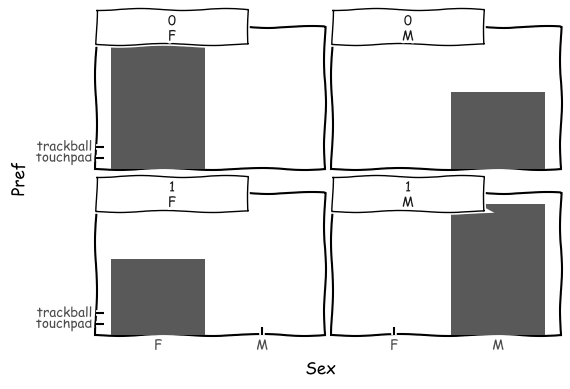

<ggplot: (285605405)>

In [144]:
(
    ggplot(df, aes(x='Sex', y='Pref')) +
    geom_bar(stat='identity') + 
    facet_wrap('~ Disability + Sex')
)

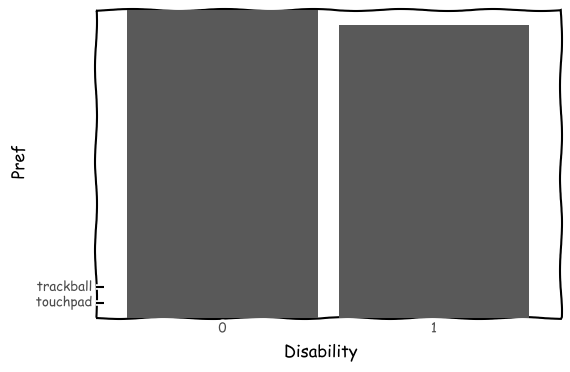

<ggplot: (285573369)>

In [145]:
(
    ggplot(df, aes(x='Disability', y='Pref')) +
    geom_bar(stat='identity')
)

In [146]:
#model = glm('Pref ~ Disability*Sex', data=df, family="binomial", contrasts=ro.vectors.ListVector(['Sex="contr.total"', 'Disability="contr.sum"']))
model = glm('Pref ~ Disability*Sex', data=df, family="binomial", contrasts='list(Sex="contr.sum", Disability="contr.sum")')

In [147]:
print(car.Anova(model, type=3))

Analysis of Deviance Table (Type III tests)

Response: Pref
               LR Chisq Df Pr(>Chisq)  
Disability       4.1657  1    0.04125 *
Sex              2.1269  1    0.14473  
Disability:Sex   0.6964  1    0.40400  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [148]:
model = multinom('Pref ~ Sex*Disability', data=df, contrasts='list(Sex="contr.sum", Disability="contr.sum")')

# weights:  5 (4 variable)
initial  value 20.794415 
iter  10 value 13.022010
iter  20 value 13.010305
final  value 13.010300 
converged


In [149]:
print(car.Anova(model, type=3))

Analysis of Deviance Table (Type III tests)

Response: Pref
               LR Chisq Df Pr(>Chisq)  
Sex              2.1264  1    0.14478  
Disability       4.1662  1    0.04124 *
Sex:Disability   0.6959  1    0.40417  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [176]:
groups1 = df.sort_values('Subject').groupby(['Disability'])
pvals = [None]*4
i = 0
for g1 in groups1.groups:
    group1 = groups1.get_group(g1)
    groups2 = group1.sort_values('Subject').groupby(['Sex'])
    for g2 in groups2.groups:
        group2 = groups2.get_group(g2)
        print group2.Sex.values[0], group2.Disability.values[0],(sum(group2.Pref == 'touchpad')), group1.Subject.size
        print group2
        pvals[i] = sm.stats.proportion.binom_test(sum((group2.Pref == 'touchpad')), group1.Subject.size, prop=1./2.)
        pvals[i] = binom_test(sum((group2.Pref == 'touchpad')), group1.Subject.size, 1./2.)[2]
        i = i + 1
pvals_corrected = p_adjust(pvals, method='holm')
print pvals
print pvals_corrected
print min(pvals_corrected)      

M 0 7 18
   Subject Disability Sex      Pref
2        3          0   M  touchpad
6        7          0   M  touchpad
10      11          0   M  touchpad
14      15          0   M  touchpad
18      19          0   M  touchpad
20      21          0   M  touchpad
24      25          0   M  touchpad
F 0 9 18
   Subject Disability Sex       Pref
3        4          0   F  trackball
5        6          0   F   touchpad
7        8          0   F   touchpad
11      12          0   F   touchpad
13      14          0   F   touchpad
15      16          0   F   touchpad
19      20          0   F   touchpad
21      22          0   F  trackball
23      24          0   F   touchpad
25      26          0   F   touchpad
27      28          0   F   touchpad
M 1 4 12
   Subject Disability Sex       Pref
0        1          1   M  trackball
4        5          1   M   touchpad
8        9          1   M  trackball
12      13          1   M   touchpad
16      17          1   M  trackball
22      23         

In [114]:
df = pd.read_csv("hwreco.csv")
df.Subject = df.Subject.astype('category')
df.Recognizer = df.Recognizer.astype('category')
df.Hand = df.Hand.astype('category')
df.Errors = df.Errors.astype('int')
df.head()

,Subject,Recognizer,Hand,Errors
0,1,A,Right,9
1,2,B,Left,8
2,3,C,Right,2
3,4,A,Left,3
4,5,B,Right,3


In [115]:
df.Subject.nunique()

50

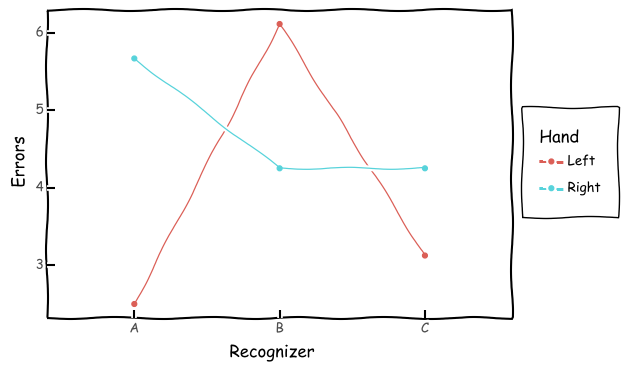

<ggplot: (285431445)>

In [116]:
groups = df.groupby(['Recognizer', 'Hand']).mean().reset_index()

(
    ggplot(groups) +
    aes(x='Recognizer', y='Errors', group = 'Hand', color='Hand') +
    geom_line() +
    geom_point()
)

In [117]:
groups = df.sort_values('Subject').groupby(['Recognizer'])
pvals = [None]*3
i = 0
for g in groups.groups:
    group = groups.get_group(g)
    fit = fitdist(ro.IntVector(group.Errors), 'pois', discrete=True)
    print 'Group: ' + group.Recognizer.values[0]
    print gofstat(fit)
    i = i + 1

Group: A
Chi-squared statistic:  1.807852 
Degree of freedom of the Chi-squared distribution:  2 
Chi-squared p-value:  0.4049767 
   the p-value may be wrong with some theoretical counts < 5  
Chi-squared table:
     obscounts theocounts
<= 2  4.000000   3.627277
<= 3  5.000000   3.168895
<= 5  4.000000   6.072436
> 5   4.000000   4.131392

Goodness-of-fit criteria
                               1-mle-pois
Akaike's Information Criterion   75.86792
Bayesian Information Criterion   76.70113

Group: C
Chi-squared statistic:  0.3521272 
Degree of freedom of the Chi-squared distribution:  2 
Chi-squared p-value:  0.8385647 
   the p-value may be wrong with some theoretical counts < 5  
Chi-squared table:
     obscounts theocounts
<= 2  5.000000   4.600874
<= 3  4.000000   3.347372
<= 4  3.000000   3.085858
> 4   4.000000   4.965897

Goodness-of-fit criteria
                               1-mle-pois
Akaike's Information Criterion   70.89042
Bayesian Information Criterion   71.66301

Group: 

In [118]:
model = glm('Errors ~ Recognizer*Hand', data=df, contrasts="sum", family='poisson')

In [119]:
print Anova(model, type=3)

Analysis of Deviance Table (Type III tests)

Response: Errors
                LR Chisq Df Pr(>Chisq)    
Recognizer        15.476  2  0.0004359 ***
Hand              10.597  1  0.0011329 ** 
Recognizer:Hand   12.968  2  0.0015276 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [135]:
summary(glht(model, lsm('pairwise ~ Recognizer*Hand')), test=adjusted(type="none"))

/usr/local/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in emmeans("pairwise ~ Recognizer*Hand", object = <S4 object of class "emmGrid">) : 
  No variable named pairwise ~ Recognizer*Hand in the reference grid

  res = super(Function, self).__call__(*new_args, **new_kwargs)


RRuntimeError: Error in emmeans("pairwise ~ Recognizer*Hand", object = <S4 object of class "emmGrid">) : 
  No variable named pairwise ~ Recognizer*Hand in the reference grid


R code that evaluates the correct result:
```
df = read.csv("hwreco.csv")
df$Recognizer <- factor(df$Recognizer)
df$Hand <- factor(df$Hand)

contrasts(df$Recognizer) <- contr.sum
contrasts(df$Hand) <- contr.sum

model = glm(Errors ~ Recognizer * Hand, data=df, family=poisson)

Anova(model, type=3)

summary(glht(model, lsm(pairwise ~ Recognizer * Hand)), test=adjusted(type="none"))
p.adjust(c(0.001925, 0.095955, 0.243171), method="holm")
```

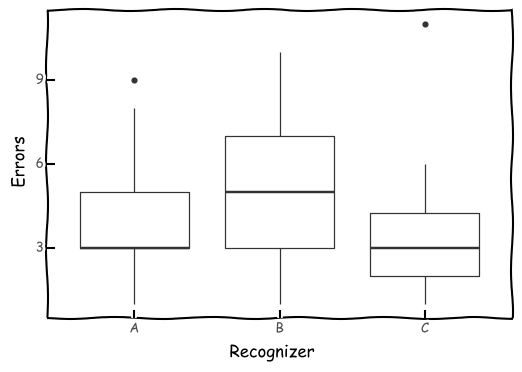

<ggplot: (294902605)>

In [85]:
(
    ggplot(df, aes(x='Recognizer', y='Errors')) +
    geom_boxplot()
)

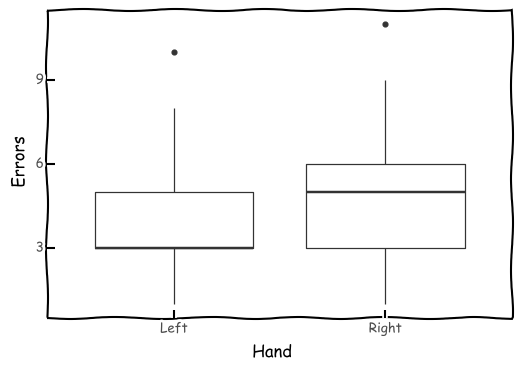

<ggplot: (295060169)>

In [86]:
(
    ggplot(df, aes(x='Hand', y='Errors')) +
    geom_boxplot()
)

In [111]:
print Anova(model, type=3)

Analysis of Deviance Table (Type III tests)

Response: Errors
                LR Chisq Df Pr(>Chisq)    
Hand              10.597  1  0.0011329 ** 
Recognizer        15.476  2  0.0004359 ***
Hand:Recognizer   12.968  2  0.0015276 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [129]:
groups = df.sort_values('Subject').groupby(['Recognizer'])
i = 0
pvals = [None]*3
for g in groups.groups:
    group = groups.get_group(g)
    model = glm('Errors ~ Hand', data=group, contrasts="sum", family='poisson')
    print 'Recognizer: ' + group.Recognizer.values[0]
    print glht(model, linfct=mcp(Hand = "Tukey"))
    a = Anova(model, type=3)
    pvals[i] = a[2]
    i = i + 1
    
pvals_corrected = p_adjust(pvals, method='holm')
print pvals
print pvals_corrected
print min(pvals_corrected)

Recognizer: A

	 General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Linear Hypotheses:
                  Estimate
Right - Left == 0   0.8183


Recognizer: C

	 General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Linear Hypotheses:
                  Estimate
Right - Left == 0   0.3075


Recognizer: B

	 General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Linear Hypotheses:
                  Estimate
Right - Left == 0  -0.3632


[<FloatVector - Python:0x1199a3488 / R:0x7fdbbec46c38>
[0.001133], <FloatVector - Python:0x11918d7a0 / R:0x7fdbbde15328>
[0.240398], <FloatVector - Python:0x119b8cf38 / R:0x7fdbbf5f5098>
[0.092108]]
[1] 0.00339871 0.24039846 0.18421615

0.00339871029302


In [110]:
print(glht(model, mcp(Recognizer = "Tukey"), test=adjusted(type="holm")))


	 General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Linear Hypotheses:
           Estimate
B - A == 0   0.8938
C - A == 0   0.2231
C - B == 0  -0.6707



	 General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Linear Hypotheses:
           Estimate
B - A == 0   0.8938
C - A == 0   0.2231
C - B == 0  -0.6707




In [6]:
df = pd.read_csv("bookflights.csv")
df.Subject = df.Subject.astype('category')
df.Website = df.Website.astype('category')
df.International = df.International.astype('category')
df.Ease = df.Ease.astype('category', ordered=True)
df['EaseAsInt'] = df.Ease.astype('int')
df.head()

/usr/local/Cellar/ipython@5/5.5.0_1/libexec/vendor/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  """


,Subject,Website,International,Ease,EaseAsInt
0,1,Expedia,1,4,4
1,2,Orbitz,1,3,3
2,3,Priceline,1,5,5
3,4,Expedia,0,1,1
4,5,Orbitz,0,7,7


In [7]:
df.Subject.nunique()

600

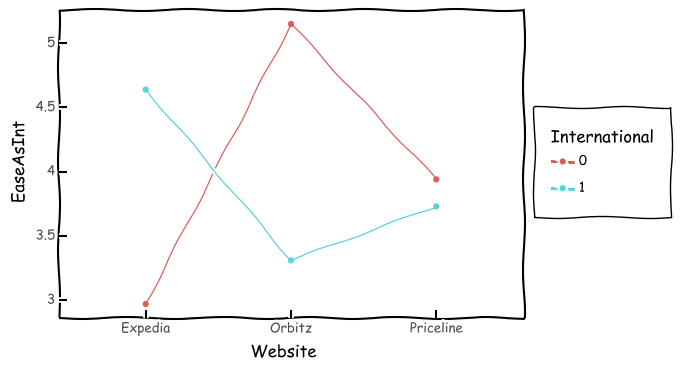

<ggplot: (283577529)>

In [8]:
groups = df.groupby(['Website', 'International']).mean().reset_index()

(
    ggplot(groups) +
    aes(x='Website', y='EaseAsInt', group = 'International', color='International') +
    geom_line() +
    geom_point()
)

In [54]:
#model = polr('Ease ~ C(Website, contr.sum)*C(International, contr.sum)', data=df, Hess=True)
model = polr('Ease ~ Website*International', data=df, Hess=True)

In [55]:
print Anova(model, type=3)

Analysis of Deviance Table (Type III tests)

Response: Ease
                      LR Chisq Df Pr(>Chisq)    
Website                 69.981  2  6.366e-16 ***
International           41.982  1  9.210e-11 ***
Website:International   90.590  2  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [94]:
lsmeans(model, 'pairwise ~ Website*International', data=df, test=adjusted(type="none"))
#p_adjust([1.44e-10, 1.35e-12, 0.474476], method="holm")

RRuntimeError: Error in emmfcn(...) : 
  No variable named pairwise ~ Website*International in the reference grid


R code that evaluates the correct result:
```
library(car)
library(lsmeans)
library(MASS)
library(multcomp)

setwd("~/Documents/repos/roland-hochmuth/designexperiments")
df = read.csv("bookflights.csv")

df$International <- factor(df$International)
df$Website <- factor(df$Website)
df$Ease <- ordered(df$Ease)

contrasts(df$Website) <- contr.sum
contrasts(df$International) <- contr.sum

model = polr('Ease ~ Website*International', data=df, Hess=TRUE)

Anova(model, type=3)

summary(as.glht(pairs(lsmeans(model, pairwise ~ Website * International, data=df))), test=adjusted(type="none"))

p.adjust(c(1.44e-10, 1.35e-12, 0.474476), method="holm")
```

In [ ]:
#model = sm.api.GLM.from_formula('Pref ~ I(Sex)*I(Disability)', data=df, family=sm.api.families.Binomial()).fit()
model = sm.formula.api.ols('Pref ~ C(Sex, contrast.sum)*C(Disability)', data=df).fit()
sm.stats.anova.anova_lm(model, typ=3)
print(model.summary())

In [ ]:
model.pvalues

In [ ]:
model = sm.api.MNLogit.from_formula('Pref ~ C(Sex)*C(Disability)', data=df).fit()
sm.stats.anova.anova3_lm_single=(model, typ=2)
print(model.summary())

In [ ]:
model.pvalues

## Answers

1. 30
2. 0.4040
3. 0.4040
4. 0.0254
5. 50
6. 2
7. 0.4050
8. 0.0015
9. 0.0058
10.
    The handwriting error counts seemed to be Poisson-distributed.
    There was a significant Recognizer * Hand interaction.
    For recognizer "A", there were significantly more errors for right-handed writers than left-handed writers.
11. 600
12. 1
13. 0.0332
14. 0.4745
15.
    There was a significant main effect of Website on Ease
    There was a significant Website * International interaction.
    Expedia was perceived as significantly easier for booking international flights than domestic flights.
    Orbitz was perceived as significantly easier for booking domestic flights than international flights.

# References

* [Interactions and ANOVA](http://www.statsmodels.org/dev/examples/notebooks/generated/interactions_anova.html)
* https://biologyforfun.wordpress.com/2015/01/13/using-and-interpreting-different-contrasts-in-linear-models-in-r/
* http://pythonhosted.org/mord/